In [1]:
from sklearn.datasets import make_friedman1
import numpy as np
import statistics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman1
import numpy as np
import statistics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# define training data size
training_num = 1000

# x-values: all uniformly distributed between 0 and 1
x0_train=np.random.rand(training_num)*0.5
x1_train=np.random.rand(training_num)*0.5
x2_train=np.random.rand(training_num)*0.5
x3_train=np.random.rand(training_num)*0.5
x4_train=np.random.rand(training_num)*0.5
X_train = [[x0_train[i], x1_train[i], x2_train[i], x3_train[i], x4_train[i]] for i in range(0,training_num)]

# y-value with friedman function
y_train = np.sin(np.pi*x0_train*x1_train) + 20*(x2_train - 0.5)**2 + 10*x3_train + 5*x4_train

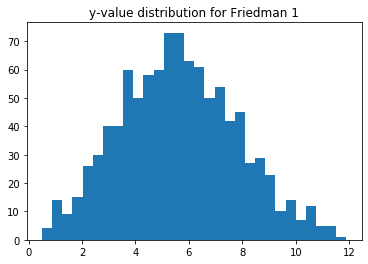

In [3]:
plt.title('y-value distribution for Friedman 1')
plt.hist(y_train, bins=30);

In [4]:
# define test data size
test_num = 100000

# x-values: add or remove the *0.5 for each one
x0_test=np.random.rand(test_num)*0.5
x1_test=np.random.rand(test_num)*0.5
x2_test=np.random.rand(test_num)*0.5
x3_test=np.random.rand(test_num)*0.5
x4_test=np.random.rand(test_num)*0.5
X_test = [[x0_test[i], x1_test[i], x2_test[i], x3_test[i], x4_test[i]] for i in range(0,test_num)]

# y-value with friedman function
y_test = np.sin(np.pi*x0_test*x1_test) + 20*(x2_test - 0.5)**2 + 10*x3_test + 5*x4_test

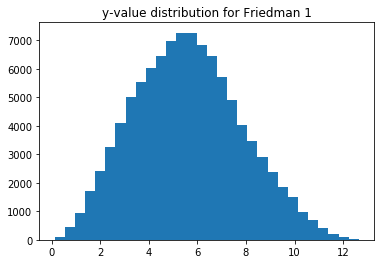

In [5]:
plt.title('y-value distribution for Friedman 1')
plt.hist(y_test, bins=30);

In [6]:
def getrfmetrics(X_train, y_train, X_test, y_test):
    regressor = RandomForestRegressor(n_estimators=145, random_state=8)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    # y_test = y_test.to_numpy(dtype=float)
    y_residual = abs(y_pred - y_test)
    y_res_no_abs = y_test - y_pred
    error = []
    for x in range(len(X_test)):
        preds = []
        for pred in regressor.estimators_:
            preds.append(pred.predict([X_test[x]])[0])
        error.append(statistics.stdev(preds))
    error = np.array(error)
    return y_residual, error, statistics.stdev(y_test), y_res_no_abs

In [7]:
def prepareplot(res, sigma, stdev, number_of_bins):
    # Define input data -- divide by standard deviation
    model_errors = sigma / stdev
    abs_res = res /stdev

    # Set bins for calculating RMS
    upperbound = np.amax(model_errors)
    lowerbound = np.amin(model_errors)
    bins = np.linspace(lowerbound, upperbound, number_of_bins, endpoint=False)

    # Create a vector determining bin of each data point
    digitized = np.digitize(model_errors, bins)

    # Record which bins contain data (to avoid trying to do calculations on empty bins)
    bins_present = []
    for i in range(1, number_of_bins + 1):
        if i in digitized:
            bins_present.append(i)
    
    # Create array of weights based on counts in each bin
    weights = []
    for i in range(1,number_of_bins + 1):
        if i in digitized:
            weights.append(np.count_nonzero(digitized == i))
    
    # Calculate RMS of the absolute residuals
    RMS_abs_res = [np.sqrt((abs_res[digitized == bins_present[i]] ** 2).mean()) for i in range(0, len(bins_present))]

    # Set the x-values to the midpoint of each bin
    bin_width = bins[1]-bins[0]
    binned_model_errors = np.zeros(len(bins_present))
    for i in range(0, len(bins_present)):
        curr_bin = bins_present[i]
        binned_model_errors[i] = bins[curr_bin-1] + bin_width/2

    # Fit a line to the data
    model = LinearRegression(fit_intercept=True)
    model.fit(binned_model_errors[:, np.newaxis],
                  RMS_abs_res, sample_weight=weights)  #### SELF: Can indicate subset of points to fit to using ":" --> "a:b"
    xfit = binned_model_errors
    yfit = model.predict(xfit[:, np.newaxis])

    # Calculate r^2 value
    r_squared = r2_score(RMS_abs_res, yfit, sample_weight=weights)
    # Calculate slope
    slope = model.coef_
    # Calculate y-intercept
    intercept = model.intercept_
    
    return model_errors, abs_res, r_squared, slope, intercept, binned_model_errors, RMS_abs_res, xfit, yfit

In [8]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
################################# RFDT ######################################
# Train RF model and get relevant data
res, sigma, std, y_res = getrfmetrics(X_train, y_train, X_test, y_test)

In [10]:
# Prepare data for plots
number_of_bins = 15
model_errors, abs_res, r_squared, slope, intercept, binned_model_errors, RMS_abs_res, xfit, yfit = prepareplot(res, sigma, std, number_of_bins)

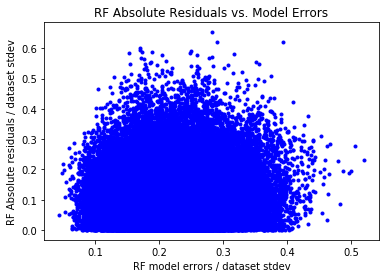

In [11]:
# Create initial scatter plot
plt.xlabel("RF model errors / dataset stdev")
plt.ylabel("RF Absolute residuals / dataset stdev")
plt.title("RF Absolute Residuals vs. Model Errors")
plt.plot(model_errors, abs_res, '.', color='blue');

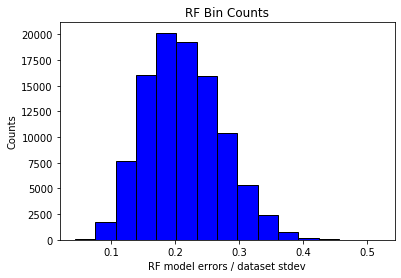

In [12]:
# Histogram of RF error bin counts
plt.hist(model_errors, bins=number_of_bins, color='blue', edgecolor='black')
plt.xlabel("RF model errors / dataset stdev")
plt.ylabel("Counts")
plt.title("RF Bin Counts");

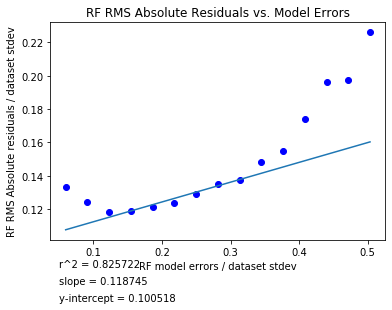

In [13]:
# Create RMS scatter plot
plt.xlabel("RF model errors / dataset stdev")
plt.ylabel("RF RMS Absolute residuals / dataset stdev")
#plt.ylim(0,1)
plt.title("RF RMS Absolute Residuals vs. Model Errors")
plt.text(0.05,0.085,'r^2 = %f' %(r_squared))
plt.text(0.05,0.075, 'slope = %f' %(slope))
plt.text(0.05,0.065, 'y-intercept = %f' %(intercept))
plt.plot(binned_model_errors, RMS_abs_res, 'o', color='blue')
plt.plot(xfit, yfit);

In [14]:
a = np.std(y_train)

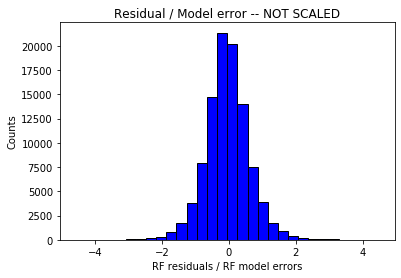

In [15]:
#plt.ylim(0,10)
plt.xlabel("RF residuals / RF model errors")
plt.ylabel("Counts")
plt.title("Residual / Model error -- NOT SCALED");
plt.hist(y_res/sigma, bins=30, color='blue', edgecolor='black');

In [16]:
print(np.mean(y_res/sigma))
print(np.std(y_res/sigma))

-0.050176829564245934
0.653133470709194


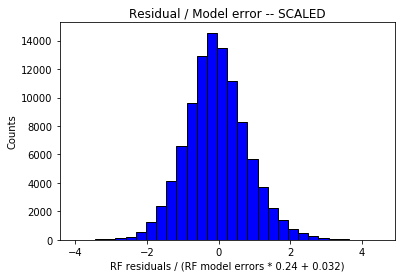

In [17]:
#plt.ylim(0,10)
plt.xlabel("RF residuals / (RF model errors * 0.24 + 0.032)")
plt.ylabel("Counts")
plt.title("Residual / Model error -- SCALED");
plt.hist((y_res/a)/((sigma/a)*0.268 + 0.090), bins=30, color='blue', edgecolor='black');

In [18]:
print(np.mean((y_res/a)/((sigma/a)*0.268+0.090)))
print(np.std((y_res/a)/((sigma/a)*0.268+0.090)))

-0.056749888585502305
0.86493776771075
